CODE BLOCK: 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_9/")

In [ ]:
from utils import *
from transform import *
from models import *
from dataset import *

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 4

In [ ]:

train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CODE BLOCK: 6

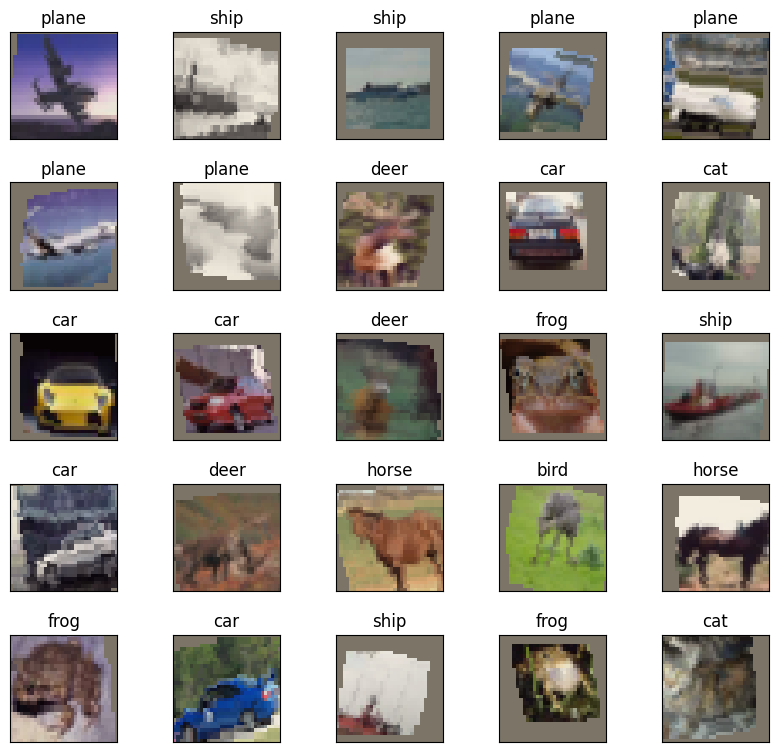

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples_cifar10(batch_data,batch_label,classes, denormalise = True)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = s9_model_1().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 31, 31]          16,416
              ReLU-8           [-1, 32, 31, 31]               0
       BatchNorm2d-9           [-1, 32, 31, 31]              64
           Conv2d-10           [-1, 32, 31, 31]           9,248
             ReLU-11           [-1, 32, 31, 31]               0
      BatchNorm2d-12           [-1, 32, 31, 31]              64
           Conv2d-13           [-1, 16, 31, 31]             528
           Conv2d-14           [-1, 64,

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 50

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=1.7043 Batch_id=97 Accuracy=28.46: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Test set: Average loss: 1.6571, Accuracy: 3650/10000 (36.50%)

Epoch 2


Train: Loss=1.4319 Batch_id=97 Accuracy=42.37: 100%|██████████| 98/98 [01:08<00:00,  1.44it/s]


Test set: Average loss: 1.4443, Accuracy: 4593/10000 (45.93%)

Epoch 3


Train: Loss=1.3604 Batch_id=97 Accuracy=49.17: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Test set: Average loss: 1.2531, Accuracy: 5427/10000 (54.27%)

Epoch 4


Train: Loss=1.2153 Batch_id=97 Accuracy=53.72: 100%|██████████| 98/98 [01:05<00:00,  1.50it/s]


Test set: Average loss: 1.1476, Accuracy: 5868/10000 (58.68%)

Epoch 5


Train: Loss=0.9814 Batch_id=97 Accuracy=58.06: 100%|██████████| 98/98 [01:07<00:00,  1.45it/s]


Test set: Average loss: 1.0930, Accuracy: 6136/10000 (61.36%)

Epoch 6


Train: Loss=1.0445 Batch_id=97 Accuracy=60.51: 100%|██████████| 98/98 [01:08<00:00,  1.44it/s]


Test set: Average loss: 0.9679, Accuracy: 6559/10000 (65.59%)

Epoch 7


Train: Loss=1.1028 Batch_id=97 Accuracy=62.79: 100%|██████████| 98/98 [01:06<00:00,  1.48it/s]


Test set: Average loss: 0.9456, Accuracy: 6653/10000 (66.53%)

Epoch 8


Train: Loss=0.9874 Batch_id=97 Accuracy=64.30: 100%|██████████| 98/98 [01:05<00:00,  1.48it/s]


Test set: Average loss: 0.9632, Accuracy: 6645/10000 (66.45%)

Epoch 9


Train: Loss=0.9100 Batch_id=97 Accuracy=65.98: 100%|██████████| 98/98 [01:05<00:00,  1.49it/s]


Test set: Average loss: 0.8947, Accuracy: 6823/10000 (68.23%)

Epoch 10


Train: Loss=0.9109 Batch_id=97 Accuracy=67.19: 100%|██████████| 98/98 [01:09<00:00,  1.42it/s]


Test set: Average loss: 0.7999, Accuracy: 7189/10000 (71.89%)

Epoch 11


Train: Loss=0.9852 Batch_id=97 Accuracy=68.40: 100%|██████████| 98/98 [01:05<00:00,  1.50it/s]


Test set: Average loss: 0.7890, Accuracy: 7226/10000 (72.26%)

Epoch 12


Train: Loss=0.9009 Batch_id=97 Accuracy=69.55: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Test set: Average loss: 0.7305, Accuracy: 7430/10000 (74.30%)

Epoch 13


Train: Loss=0.8073 Batch_id=97 Accuracy=70.40: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Test set: Average loss: 0.7664, Accuracy: 7279/10000 (72.79%)

Epoch 14


Train: Loss=0.7504 Batch_id=97 Accuracy=71.18: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Test set: Average loss: 0.6828, Accuracy: 7577/10000 (75.77%)

Epoch 15


Train: Loss=0.7373 Batch_id=97 Accuracy=71.94: 100%|██████████| 98/98 [01:04<00:00,  1.51it/s]


Test set: Average loss: 0.6933, Accuracy: 7525/10000 (75.25%)

Epoch 16


Train: Loss=0.7629 Batch_id=97 Accuracy=72.76: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Test set: Average loss: 0.6678, Accuracy: 7650/10000 (76.50%)

Epoch 17


Train: Loss=0.7554 Batch_id=97 Accuracy=73.62: 100%|██████████| 98/98 [01:05<00:00,  1.50it/s]


Test set: Average loss: 0.7163, Accuracy: 7552/10000 (75.52%)

Epoch 18


Train: Loss=0.7530 Batch_id=97 Accuracy=73.84: 100%|██████████| 98/98 [01:04<00:00,  1.53it/s]


Test set: Average loss: 0.6897, Accuracy: 7617/10000 (76.17%)

Epoch 19


Train: Loss=0.7971 Batch_id=97 Accuracy=74.47: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Test set: Average loss: 0.6141, Accuracy: 7903/10000 (79.03%)

Epoch 20


Train: Loss=0.7624 Batch_id=97 Accuracy=75.03: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Test set: Average loss: 0.6376, Accuracy: 7829/10000 (78.29%)

Epoch 21


Train: Loss=0.7725 Batch_id=97 Accuracy=75.44: 100%|██████████| 98/98 [01:05<00:00,  1.51it/s]


Test set: Average loss: 0.6245, Accuracy: 7828/10000 (78.28%)

Epoch 22


Train: Loss=0.5600 Batch_id=97 Accuracy=75.71: 100%|██████████| 98/98 [01:05<00:00,  1.50it/s]


Test set: Average loss: 0.5830, Accuracy: 7972/10000 (79.72%)

Epoch 23


Train: Loss=0.7172 Batch_id=97 Accuracy=76.30: 100%|██████████| 98/98 [01:04<00:00,  1.51it/s]


Test set: Average loss: 0.6109, Accuracy: 7899/10000 (78.99%)

Epoch 24


Train: Loss=0.7487 Batch_id=97 Accuracy=76.34: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Test set: Average loss: 0.6058, Accuracy: 7917/10000 (79.17%)

Epoch 25


Train: Loss=0.6505 Batch_id=97 Accuracy=76.97: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Test set: Average loss: 0.5819, Accuracy: 7983/10000 (79.83%)

Epoch 26


Train: Loss=0.5285 Batch_id=97 Accuracy=77.41: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Test set: Average loss: 0.5306, Accuracy: 8185/10000 (81.85%)

Epoch 27


Train: Loss=0.6788 Batch_id=97 Accuracy=77.40: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Test set: Average loss: 0.5553, Accuracy: 8096/10000 (80.96%)

Epoch 28


Train: Loss=0.6646 Batch_id=97 Accuracy=78.29: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Test set: Average loss: 0.5549, Accuracy: 8122/10000 (81.22%)

Epoch 29


Train: Loss=0.6731 Batch_id=97 Accuracy=78.39: 100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Test set: Average loss: 0.6000, Accuracy: 7980/10000 (79.80%)

Epoch 30


Train: Loss=0.7563 Batch_id=97 Accuracy=78.33: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Test set: Average loss: 0.5569, Accuracy: 8092/10000 (80.92%)

Epoch 31


Train: Loss=0.5403 Batch_id=97 Accuracy=78.44: 100%|██████████| 98/98 [01:04<00:00,  1.53it/s]


Test set: Average loss: 0.5330, Accuracy: 8153/10000 (81.53%)

Epoch 32


Train: Loss=0.6903 Batch_id=97 Accuracy=78.75: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Test set: Average loss: 0.5396, Accuracy: 8188/10000 (81.88%)

Epoch 33


Train: Loss=0.5837 Batch_id=97 Accuracy=78.65: 100%|██████████| 98/98 [01:04<00:00,  1.53it/s]


Test set: Average loss: 0.5333, Accuracy: 8175/10000 (81.75%)

Epoch 34


Train: Loss=0.6638 Batch_id=97 Accuracy=79.16: 100%|██████████| 98/98 [01:05<00:00,  1.51it/s]


Test set: Average loss: 0.5566, Accuracy: 8128/10000 (81.28%)

Epoch 35


Train: Loss=0.5726 Batch_id=97 Accuracy=79.44: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]


Test set: Average loss: 0.5292, Accuracy: 8207/10000 (82.07%)

Epoch 36


Train: Loss=0.6454 Batch_id=97 Accuracy=79.83: 100%|██████████| 98/98 [01:07<00:00,  1.46it/s]


Test set: Average loss: 0.5045, Accuracy: 8299/10000 (82.99%)

Epoch 37


Train: Loss=0.5294 Batch_id=97 Accuracy=79.84: 100%|██████████| 98/98 [01:07<00:00,  1.45it/s]


Test set: Average loss: 0.4795, Accuracy: 8331/10000 (83.31%)

Epoch 38


Train: Loss=0.4909 Batch_id=97 Accuracy=80.31: 100%|██████████| 98/98 [01:06<00:00,  1.46it/s]


Test set: Average loss: 0.4795, Accuracy: 8362/10000 (83.62%)

Epoch 39


Train: Loss=0.6013 Batch_id=97 Accuracy=80.21: 100%|██████████| 98/98 [01:06<00:00,  1.48it/s]


Test set: Average loss: 0.5295, Accuracy: 8203/10000 (82.03%)

Epoch 40


Train: Loss=0.5836 Batch_id=97 Accuracy=80.37: 100%|██████████| 98/98 [01:05<00:00,  1.49it/s]


Test set: Average loss: 0.4744, Accuracy: 8394/10000 (83.94%)

Epoch 41


Train: Loss=0.4472 Batch_id=97 Accuracy=80.73: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Test set: Average loss: 0.5029, Accuracy: 8272/10000 (82.72%)

Epoch 42


Train: Loss=0.5154 Batch_id=97 Accuracy=80.56: 100%|██████████| 98/98 [01:04<00:00,  1.51it/s]


Test set: Average loss: 0.4768, Accuracy: 8347/10000 (83.47%)

Epoch 43


Train: Loss=0.4541 Batch_id=97 Accuracy=80.83: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Test set: Average loss: 0.4822, Accuracy: 8355/10000 (83.55%)

Epoch 44


Train: Loss=0.5588 Batch_id=97 Accuracy=80.97: 100%|██████████| 98/98 [01:05<00:00,  1.50it/s]


Test set: Average loss: 0.4973, Accuracy: 8305/10000 (83.05%)

Epoch 45


Train: Loss=0.4520 Batch_id=97 Accuracy=81.14: 100%|██████████| 98/98 [01:06<00:00,  1.48it/s]


Test set: Average loss: 0.5044, Accuracy: 8317/10000 (83.17%)

Epoch 46


Train: Loss=0.5165 Batch_id=97 Accuracy=81.14: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s]


Test set: Average loss: 0.4796, Accuracy: 8370/10000 (83.70%)

Epoch 47


Train: Loss=0.5658 Batch_id=97 Accuracy=81.48: 100%|██████████| 98/98 [01:05<00:00,  1.49it/s]


Test set: Average loss: 0.4810, Accuracy: 8363/10000 (83.63%)

Epoch 48


Train: Loss=0.4208 Batch_id=97 Accuracy=81.38: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Test set: Average loss: 0.4791, Accuracy: 8345/10000 (83.45%)

Epoch 49


Train: Loss=0.4942 Batch_id=97 Accuracy=81.58: 100%|██████████| 98/98 [01:03<00:00,  1.53it/s]


Test set: Average loss: 0.4666, Accuracy: 8405/10000 (84.05%)

Epoch 50


Train: Loss=0.4786 Batch_id=97 Accuracy=81.84: 100%|██████████| 98/98 [01:04<00:00,  1.52it/s]


Test set: Average loss: 0.4626, Accuracy: 8463/10000 (84.63%)



CODE BLOCK: 11

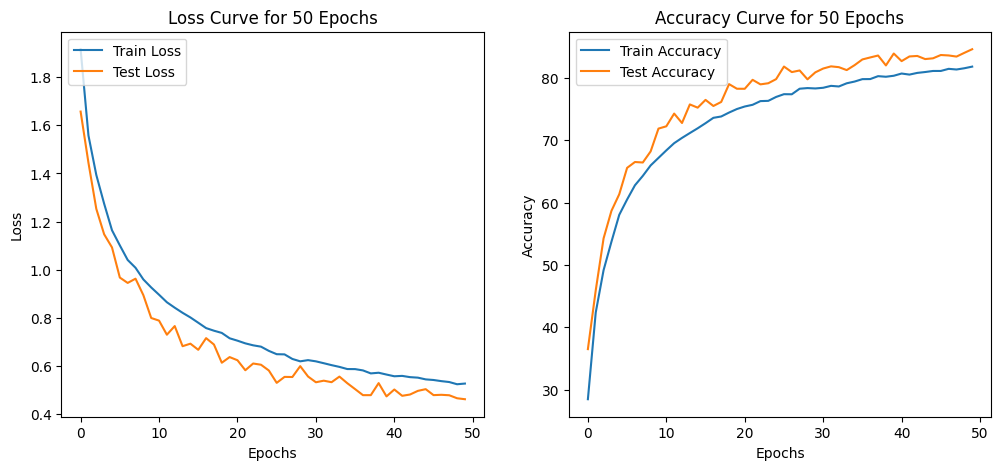

In [ ]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc,num_epochs)

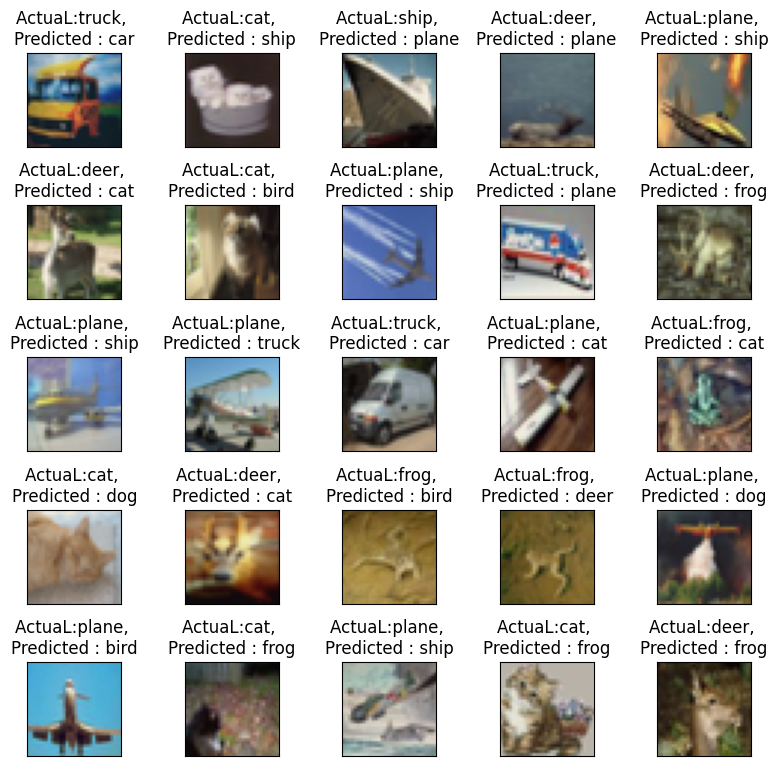

In [ ]:
# Show Misclassified images
for batch_idx, (data, target) in enumerate(test_loader):
  data, target = data.to(device), target.to(device)
  output = model(data)
  output_label = output.argmax(dim=1)
  op_ne_target = output.argmax(dim=1).ne(target)
  actual_label = target[op_ne_target].to('cpu')
  predicted_label = output_label[op_ne_target].to('cpu')
  images = data[op_ne_target].to('cpu')
  plot_misclassified_samples(images, actual_label, predicted_label,classes,unorm)
  break
